In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
eq_df = pd.read_csv('tempdata/earthquakes_catalog.csv', sep='|')

In [6]:
"""
#Add column for year
years = []
for time in eq_df['origintime']:
    year = int(str.split(time, '-')[0])
    years.append(year)
    #index = time.key
year_column = pd.Series(years, index=eq_df.index)
eq_df['year'] = year_column
"""

"\n#Add column for year\nyears = []\nfor time in eq_df['origintime']:\n    year = int(str.split(time, '-')[0])\n    years.append(year)\n    #index = time.key\nyear_column = pd.Series(years, index=eq_df.index)\neq_df['year'] = year_column\n"

In [7]:
eq_df.head()

,Unnamed: 0,id,origintime,latitude,longitude,depth,county,origin_src,prefmag,pmag_type,pmag_src,m3hz_ogs,md_ogs,geom,year_float
0,0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,CANADIAN,OGS,1.9,M3Hz,OGS,1.9,1.7,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,1980.130
1,1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,GARFIELD,OGS,1.7,M3Hz,OGS,1.7,1.4,0101000020E61000000C022B87166958C0448B6CE7FB39...,1980.320
2,2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,LOVE,OGS,2.2,M3Hz,OGS,2.2,2.0,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,1980.920
3,3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,LOVE,OGS,2.1,M3Hz,OGS,2.1,1.9,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,1980.980
4,4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,HASKELL,OGS,1.2,M3Hz,OGS,1.2,1.4,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,1980.188


# Miscellaneous things to add to final notebook

#0.1 Additional Imports

In [8]:
import datetime
#import statsmodels.formula.api as sm
import statsmodels.api as sm

#0.2 Poisson Process Code

#0.2.1 No Recent Changes

In [9]:
#function to create list of interarrival times in hours from df 
#1
def get_hours_between(df):
    dates=[]
    origintimes = df.origintime.values
    for date in origintimes:
        year, month, day = date.split('-')
        day, hour = day.split(' ')
        hour, minute, second = hour.split(':')
        if len(second.split('.'))==2:
            second, microsecond = second.split('.')
        elif len(second.split('.'))==1:
            microsecond=0
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), 
                                       int(second), int(microsecond)))
    dates=sorted(dates)
    deltas=[]
    for i in range(1,len(dates)):
        delta = dates[i] - dates[i-1]
        delta = delta.total_seconds()/3600
        deltas.append(delta)
    deltas = np.array(deltas)
    return deltas

#0.2.2 Recent Changes, Need to add to Final

#This is a fully complex version of the Poisson Process Code. Simplified version below

In [10]:
#2
#fit and plot exponential to data
#k is manual assessment of number of parameters
def fit_expo(deltas, bins=100, xmax=100, ymax=0.02, k=1., force_lambd=None, plot=True):
    #Use Maxmimum Likelihood Estimator to get exponential fit
    expo_fit = sp.stats.expon.fit(deltas, floc=0)
    
    #Calculate Summary Statistics
    k=float(k)
    mean = np.mean(deltas) #sample mean
    if pd.isnull(force_lambd):
        lambd = expo_fit[1] #fitted mean
    else:
        lambd=force_lambd
    n = float(len(deltas))
    ks_d, ks_pval=sp.stats.kstest(deltas, 'expon', alternative='two-sided')
    ppstats = sp.stats.probplot(deltas, dist='expon')
    r = ppstats[1][2]
    r2 = r**2
    log_lik = n*np.log(lambd) - lambd*np.sum(deltas)
    aic = 2*k - 2*log_lik
    ssr = np.sum((deltas-lambd)**2)
    aic2 = n*np.log(ssr/n) + 2*k
    aic_c = aic + float(((2*k)*(k+1))/(n-k-1))
    mse = np.mean((deltas-lambd)**2)
    ad = sp.stats.anderson(deltas, dist='expon')
    ad_stat = ad[0]
    ad_critical_value = ad[1][2]

    
    if plot==True:
        #Overlay fitted exponential over histogram
        plt.hist(deltas, bins=bins, normed=True)
        x = np.arange(0,xmax,0.01)
        y = sp.stats.expon.pdf(x, scale=lambd)
        plt.plot(x,y)
        plt.xlim([0,xmax])
        plt.ylim([0,ymax])

        #QQ Plot for fit to exponential
        sm.qqplot(deltas, dist='expon', fit=True, line='45')
        plt.show()
    
    #Print Summary Statistics
    print "Summary Statistics for Distributional Fit"
    print "lambda = " + str(lambd)
    print "mean(data) = " + str(mean)
    print "sample size = " + str(n)
    print "AIC = " + str(aic) + "??" 
    print "AICc = " + str(aic_c) + "??"
    print "ssr= " + str(ssr) 
    print "AIC2 =" + str(aic2) + "??"
    print "Summary Statistics for Predicton"
    print "MSE = " + str(mse)
    print "####Not Updated for Comparing Models#####"
    print "Kolmogorov-Smirnov Test Statistic D=" + str(ks_d)
    print "Kolmogorov-Smirnov Test p-value=" + str(ks_pval)
    print "QQ R^2 = " + str(r2)
    print "AD Stat = " + str(ad_stat)
    print "AD Critical Value = " + str(ad_critical_value)
    return(lambd, mean, n, ks_d, ks_pval, r2, aic)

In [11]:
#3
#get interarrival times for whole df
def show_expo_fit(df, bins=40, xmax=10000, ymax=0.001, k=1., force_lambd=None, plot=True):
    deltas = get_hours_between(df)
    fit = fit_expo(deltas, bins=bins, xmax=xmax, ymax=ymax, k=k, force_lambd=force_lambd, plot=plot)
    lambd = fit[0]
    return lambd

Add Chi-Squared Goodness of Fit Test http://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm

Note: Could also fit to Poisson

Note: Look into "fit" algorithm in scipy, statsmodels

Note: Is this the standard plot for showing distributional fit? 

Note: Need to look into understanding QQ Plots and Probability Plots

Use AIC for comparing distributional fit.

    *Starting Point: Given taht this is the correct distribution, what is the log-likelihood of the data?
    
    *if the number of data points is small, then some correction is often necessary (see AICc, below).
    
    *\mathrm{AIC} = 2k - 2\ln(L)
    *Important websites: http://www.easydatascience.com
    *http://stats.stackexchange.com/questions/31768/is-it-okay-to-compare-fitted-distributions-with-the-aic

Look into nonparametric methods for simulating the distribution here.

Look into this further: http://www.geos.ed.ac.uk/homes/abell5/Modelcode.html

Power Law as a Model for Earthquakes

#This is a simplified version of Poisson Process Code for use.

In [33]:
#2
#Notes: See here:
#http://statsmodels.sourceforge.net/devel/generated/statsmodels.graphics.gofplots.ProbPlot.html
#fit and plot exponential to data
def fit_expo(deltas, plot=True, bins=100, xmax=100, ymax=0.02, k=1., force_lambd=None, summary_stats=True):
    #If we are inherting a previous model for comparison, use previous lambda
    if pd.notnull(force_lambd):
        #Calculate Summary Statistics
        lambd=force_lambd
        mean = np.mean(deltas) #sample mean
 
    #If we are fitting the model on this dataset separately, calculate lambda from data
    elif pd.isnull(force_lambd):
        #Use Maxmimum Likelihood Estimator to get exponential fit
        expo_fit = sp.stats.expon.fit(deltas, floc=0)
        #Calculate Summary Statistics
        lambd = expo_fit[1] #fitted mean
        #mean = lambd
        
    #Calculate more summary statistics
    k=float(k)
    n = float(len(deltas))
    ssr = np.sum((deltas-lambd)**2)
    aic = n*np.log(ssr/n) + 2*k
    mse = np.mean((deltas-lambd)**2)  
        
    if plot==True:
        #Overlay fitted exponential over histogram
        f, axes = plt.subplots(nrows=int(1), ncols=int(2), squeeze=False)
        f.set_figheight(5)
        f.set_figwidth(12)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
        axes[0][0].hist(deltas, bins=bins, normed=True, zorder=0, color='grey', 
                        label='Hours')
        x = np.arange(0,xmax,0.01)
        y = sp.stats.expon.pdf(x, scale=lambd)
        axes[0][0].grid(False) 
        axes[0][0].plot(x,y, color='green', zorder=10, label='Exponential PDF')
        axes[0][0].set_xlim(0,xmax)
        axes[0][0].set_ylim(0,ymax)
        axes[0][0].legend()
        axes[0][0].set_title('Hours Between Quakes')
        #QQ Plot for fit to exponential
        ppstats = sm.ProbPlot(deltas, sp.stats.expon, loc=0, scale=lambd)
        
        #Calculate one more summary statistic
        t_quants = ppstats.theoretical_quantiles #x
        s_quants = ppstats.sample_quantiles #y
        y_fit = t_quants
        qq_ssr = np.sum((s_quants-y_fit)**2)
        qq_sst = np.sum((s_quants-np.mean(s_quants))**2)
        qq_r2 = 1-(qq_ssr/qq_sst)
        
        #Another plot
        #QQ's
        axes[0][1].scatter(t_quants,s_quants, marker='o', color='green')
        #45 degree reference line
        x = np.arange(0,20000, 1.)
        y = x
        axes[0][1].plot(x,y, color='gray')
        axes[0][1].grid(False)
        axes[0][1].set_xlim(0,20000)
        axes[0][1].set_ylim(0,20000)
        axes[0][1].set_title('QQ Plot')
        
        
    #Print Summary Statistics
    if summary_stats==True:
        print "Summary Statistics for Distributional Fit"
        print "lambda = " + str(lambd)
        if pd.notnull(force_lambd):
            print "sample mean = " + str(mean)
        print "sample size = " + str(n)
        print "AIC = " + str(aic) 
        print "QQ R^2 = " + str(qq_r2)
        print "Summary Statistics for Prediction"
        print "MSE = " + str(mse)
        
    return(lambd, n, aic, k, mse, qq_r2, t_quants, s_quants)
    #return(lambd, mean, n, aic, k, mse)

#1 Baseline fit is not good

Summary Statistics for Distributional Fit
lambda = 179.553239946
sample size = 1782.0
AIC = 25292.0044564
QQ R^2 = 0.146148711229
Summary Statistics for Prediction
MSE = 1457046.05289


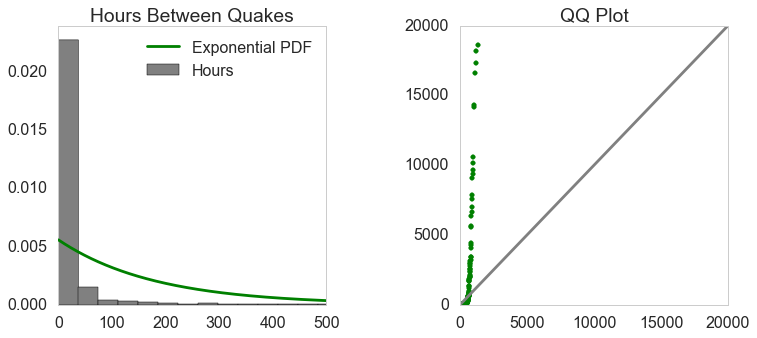

In [34]:
deltas1 = get_hours_between(eq_df[eq_df.prefmag>=3])
summary1 = fit_expo(deltas1, plot=True, bins=500, xmax=500, ymax=0.024, k=1., 
                    force_lambd=None, summary_stats=True)

#2 Splitting at 2010 is better: pre-2010 looks like Poisson Process

This is how well the previous model predicted the data before 2010.

179.553239946
Summary Statistics for Distributional Fit
lambda = 179.553239946
sample mean = 5487.62963948
sample size = 47.0
AIC = 857.285632977
QQ R^2 = -0.502666070983
Summary Statistics for Prediction
MSE = 80002357.3498


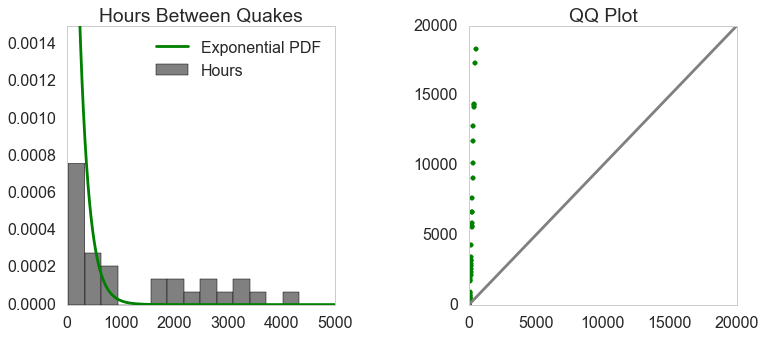

In [35]:
print summary1[0]
deltas2 = get_hours_between(eq_df[(eq_df.prefmag>3) & (eq_df.year_float<2010)])
summary2 = fit_expo(deltas2, plot=True, bins=100, xmax=5000, ymax=0.0015, k=1., force_lambd=summary1[0], summary_stats=True)

This is the fit when we do split the data

Summary Statistics for Distributional Fit
lambda = 5487.62951854
sample size = 47.0
AIC = 838.880536803
QQ R^2 = 0.865357876355
Summary Statistics for Prediction
MSE = 51826682.2866


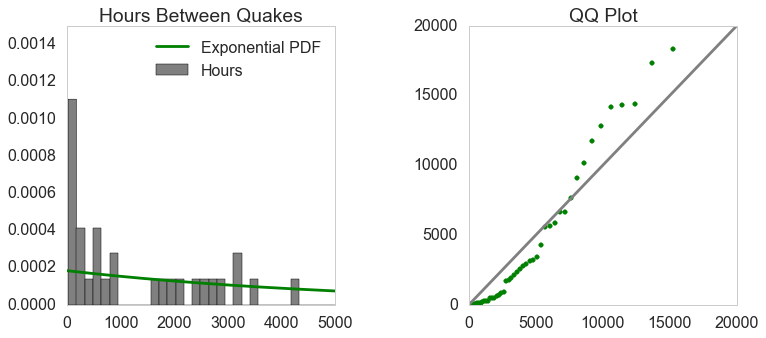

In [36]:
summary3 = fit_expo(deltas2, plot=True, bins=200, xmax=5000, ymax=0.0015, k=2., force_lambd=None, summary_stats=True)

#Exponential Regression

In [41]:
#Exponential Regression
x = np.arange(1,100,1)
y = np.random.poisson(x)
df = pd.DataFrame({'x': x, 'y': y}, index=range(1,100))

exponential_model = sm2.GLM(y,x, sm.families.family.Poisson(sm.genmod.families.links.identity))
exp_model = exponential_model.fit()
print exp_model.summary()
plt.plot(x,y)

#ols_model = sm.ols(formula = 'y~x', data = df).fit()
#print ols_model.summary()
#df.head()

AttributeError: 'module' object has no attribute 'families'

In [184]:
sm.families.family.Poisson.links

[statsmodels.genmod.families.links.log,
 statsmodels.genmod.families.links.identity,
 statsmodels.genmod.families.links.sqrt]